In [39]:
import numpy as np
import pandas as pd
import math
import time
from scipy.stats import mode
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Read in the export of the  df.karger dataframe (data processing done in R script)
df_karger = pd.read_csv("df_for_karger_MAIN.csv")

# Main Function Implementing Karger Weighting Algorithm

In [41]:
### Primary Function Implemnting the Karger Algorithm
# I modified using the starting point at this repository: https://github.com/jpgard/budget-optimal-task-allocation-crowdsourcing

def run_karger(G, A, m, n, max_num_iters):
    e_i, e_j = np.nonzero(G)

    for k in range(max_num_iters):

        # initialize empty x message array
        x_k = np.full((m, n), np.nan)
        # initialize entries of Y with N(1,1) random variables
        y_k = np.random.normal(loc=1, scale=1, size=(m, n))
        # update the task message; represents the log-likelihood of task i being a positive task
        for i, j in zip(e_i, e_j):
            # delta_i_not_j, neighborhood of i excluding j (all workers assigned to task i excluding j)
            delta_i = np.nonzero(G[i, :])[1]
            delta_i_not_j = delta_i[delta_i != j]
            x_k[i, j] = np.nansum([A[i, j_prime] * y_k[i, j_prime] for j_prime in delta_i_not_j])
            
        # update the worker message; represents how reliable worker j is
        for i, j in zip(e_i, e_j):
            # delta_j_not_i; neighborhood of j excluding i (all tasks assigned to worker j excluding i)
            delta_j = np.nonzero(G[:, j])[0]
            delta_j_not_i = delta_j[delta_j != i]
            y_k[i, j] = np.nansum([A[i_prime, j] * x_k[i_prime, j] for i_prime in delta_j_not_i])

    # compute final estimates
    x = np.full(m, np.nan)

    for i in range(m):
        neighborhood_of_i = np.unique(np.nonzero(G)[1]) # all workers who did i
        x[i] = np.nansum([A[i, j] * y_k[i, j] for j in neighborhood_of_i])
    t_hat = np.sign(x)
    return(t_hat)

In [42]:
# Main code that calls the function on the input data

# final_results = pd.DataFrame() # for final task labels

# for task_name in df_karger["task_name"].unique():
#     answer_matrix = df_karger[df_karger["task_name"] == task_name].pivot(index = "question_name", columns = "name", values = "value")
    
#     questions = answer_matrix.index
#     workers = answer_matrix.columns

#     num_workers = len(workers)
#     num_questions = len(questions)
#     G = np.asmatrix(answer_matrix)

#     # set some basic parameters
#     max_num_iters = 1000
#     # number of tasks (in this case, this is the  number of questions)
#     m = num_questions
#     # number of workers
#     n = num_workers
#     A = G

#     karger_results = run_karger(G, A, m, n, max_num_iters)
#     results_for_task = karger_results

#     # Concat the result to the database of answers
#     final_export = np.where(results_for_task == -1, 0, 1)
#     final_task_results = pd.DataFrame({task_name: final_export}, index = questions)
#     final_results = pd.concat([final_results, final_task_results], axis = 1)

# final_results.to_csv('karger-results.csv')

# Robustness Tests

"To test the algorithm, try simulating a situation where not everyone did everything. But some workers are missing some question-task pairs. For example, if every worker did 10% of the task-question pairs (with overlaps). Then test the mod/average vs the karger algorithm."

"That would simulate a situation where each worker would do 7 out of the 70 tasks or so. Maybe try again with each worker doing %20 of the question-task pairs"

In [43]:
def correctedMode(arr): # corrects for ties
  if(len(pd.Series.mode(arr))>1):
    return 0.5
  else: return(pd.Series.mode(arr))

In [44]:
# karger_results_with_limited_labels = pd.DataFrame() # for final task labels
# modal_results = pd.DataFrame() # for results with just the modal value

# for task_name in df_karger["task_name"].unique():
#     answer_matrix = df_karger[df_karger["task_name"] == task_name].pivot(index = "question_name", columns = "name", values = "value")

#     questions = answer_matrix.index
#     workers = answer_matrix.columns

#     num_workers = len(workers)
#     num_questions = len(questions)

#     # modify the answer matrix to get rid of some responses
#     # version 1: let's set it so that only a random 20% of responses are kept
    
#     # workers_to_drop = random.sample(range(num_workers), round(0.8*num_workers)) # confirmed that each time we select a random subset of 10
#     # print(workers_to_drop)
#     # answer_matrix = pd.DataFrame(answer_matrix).drop(pd.DataFrame(answer_matrix).columns[workers_to_drop], axis = 1)
#     # questions = answer_matrix.index # then reset all these numbers :)
#     # workers = answer_matrix.columns
#     # num_workers = len(workers)
#     # num_questions = len(questions)

#     # alternate version: RANDOMLY clear 80% of cells
#     for col in answer_matrix.columns:
#         answer_matrix.loc[answer_matrix.sample(frac=0.8).index, col] = np.nan 

#     G = np.asmatrix(answer_matrix)

#     # set some basic parameters
#     max_num_iters = 1000
#     # number of tasks (in this case, this is the  number of questions)
#     m = num_questions
#     # number of workers
#     n = num_workers
#     A = G

#     karger_results = run_karger(G, A, m, n, max_num_iters)
#     results_for_task = karger_results

#     # Concat the result to the database of answers
#     final_export = np.where(results_for_task == -1, 0, 1)
#     final_task_results = pd.DataFrame({task_name: final_export}, index = questions)
#     karger_results_with_limited_labels = pd.concat([karger_results_with_limited_labels, final_task_results], axis = 1)

#     # Concat the result to get the mode
#     modes = answer_matrix.agg(correctedMode, axis = 1)
#     modal_results = pd.concat([modal_results, pd.DataFrame(np.where(modes == -1, 0, 1), columns = [task_name])], axis = 1)

# Evaluate Against Ground Truth

First, load the ground truth

Just print out the mean version of the ground truth as a reference

In [45]:
ground_truth_csv = pd.read_csv("./linnemilymabdullah_ground_truth.csv")
ground_truth_mean = ground_truth_csv.loc[(ground_truth_csv['value']==1) | (ground_truth_csv['value']==0)]
ground_truth_mean = ground_truth_mean.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mode Version
ground_truth_mean = ground_truth_mean.pivot(index = "question_name", columns = "task_name")
ground_truth_mean.columns = ground_truth_mean.columns.droplevel(0)
ground_truth_mean

task_name,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,0.00,1.00,1.00,1.000000
Q11optimizing,0.75,1.00,0.50,0.000000
Q13outcome_multip,0.00,1.00,1.00,0.333333
Q14sol_scheme_mul,0.00,0.00,0.00,0.000000
Q15dec_verifiability,1.00,1.00,1.00,1.000000
Q16shared_knowledge,1.00,1.00,0.75,1.000000
Q17within_sys_sol,1.00,1.00,1.00,1.000000
Q18ans_recog,1.00,1.00,0.75,1.000000
Q19time_solvability,1.00,1.00,1.00,1.000000


# Take a look at the task map

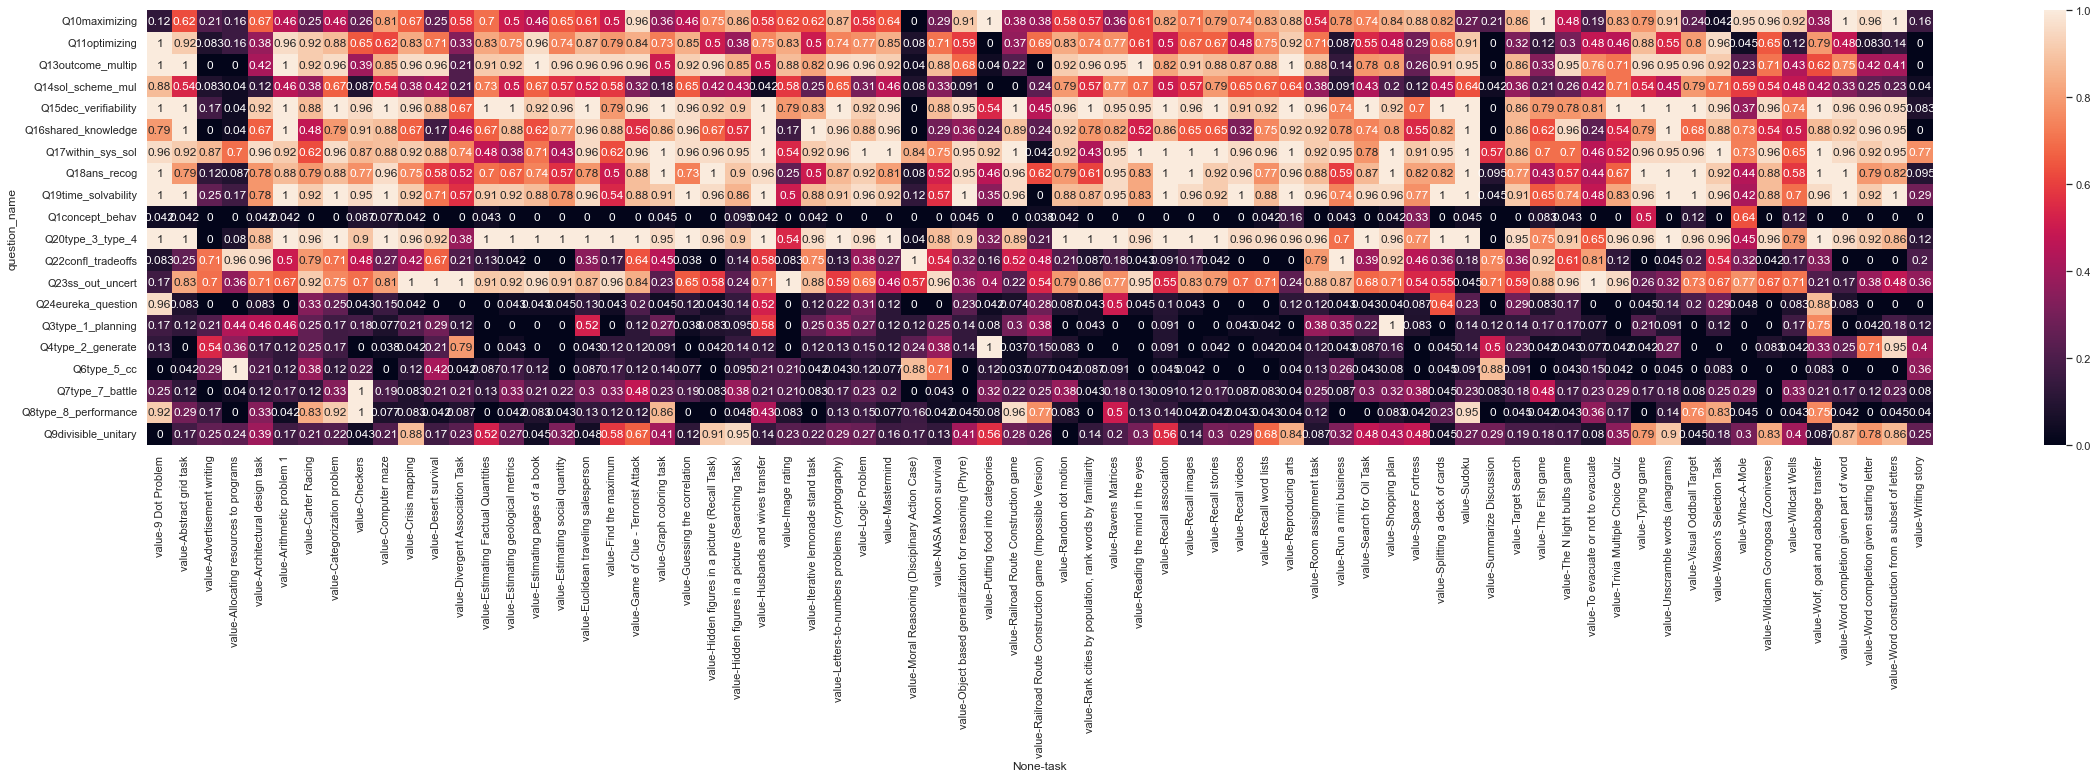

In [46]:
df_karger_filtered_recoded = df_karger.replace(-1, 0)
mean_filtered_results_all = df_karger_filtered_recoded.groupby(["question_name", "task"], as_index=False).agg(np.mean) # mean Version
mean_filtered_results_all = mean_filtered_results_all.pivot(index = "question_name", columns = "task")

sns.heatmap(abs(mean_filtered_results_all), annot=True, vmin = 0, vmax = 1)
sns.set(rc = {'figure.figsize':(40,8)})

## Compare to Ground Truth

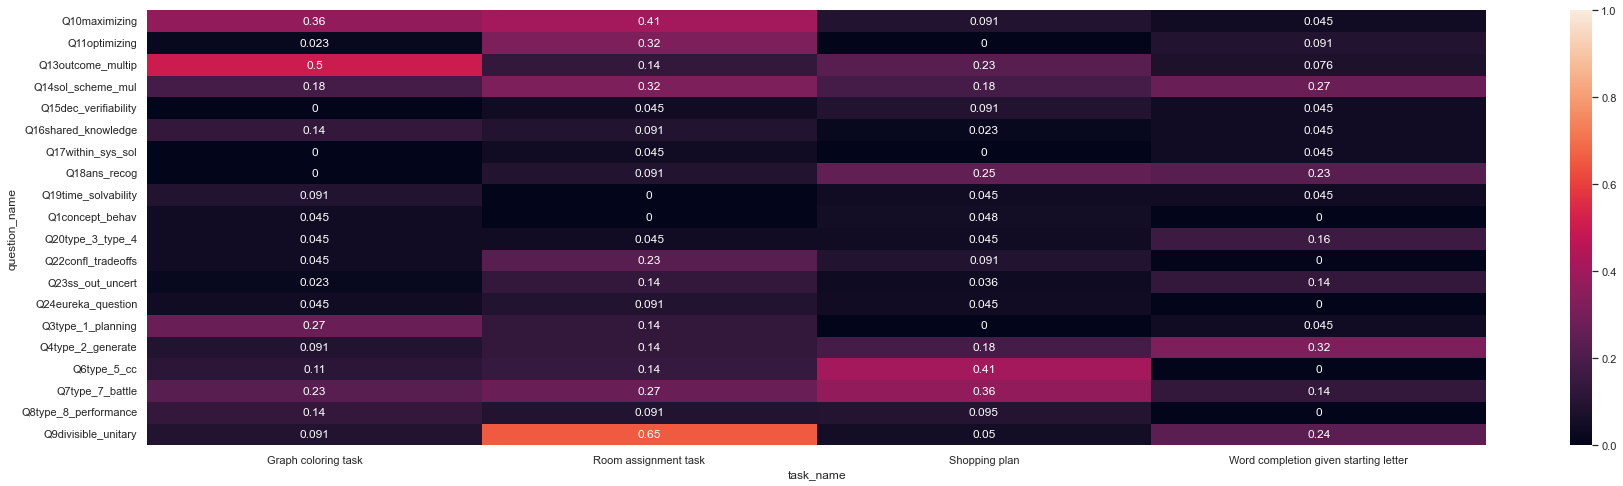

In [27]:
df_karger_filtered_recoded_gold_4 = df_karger_filtered_recoded[ (df_karger_filtered_recoded["task"] == "Graph coloring task") | (df_karger_filtered_recoded["task"] == "Room assignment task") | (df_karger_filtered_recoded["task"] == "Shopping plan") | (df_karger_filtered_recoded["task"] == "Word completion given starting letter")]

mean_filtered_results_4 = df_karger_filtered_recoded_gold_4.groupby(["question_name", "task"], as_index=False).agg(np.mean) # mean Version
mean_filtered_results_4 = mean_filtered_results_4.pivot(index = "question_name", columns = "task")
mean_filtered_results_4.columns = ground_truth_mean.columns
sns.heatmap(abs(mean_filtered_results_4-ground_truth_mean), annot=True, vmin = 0, vmax = 1)
sns.set(rc = {'figure.figsize':(6,4)})

In [17]:
np.sum(np.sum(abs(mean_filtered_results_4-ground_truth_mean))) # sum of all errors

10.799999999999999

## What happens when we drop the worst people?

In [ ]:
worker_dict = {}
worker_dict_shopping = {}
worker_dict_word = {}
worker_dict_room = {}
worker_dict_graph = {}

## Set this up to calculate based on just 1 of the tasks, and evaluate on 3 of them
df_karger_shopping_only = df_karger[df_karger["task_name"]=="Shopping plan"]
df_karger_word_only = df_karger[df_karger["task_name"]=="Word completion given starting letter"]
df_karger_room_only = df_karger[df_karger["task_name"]=="Room assignment task"]
df_karger_graph_only = df_karger[df_karger["task_name"]=="Graph coloring task"]

for name in df_karger["name"].unique():
    # includes all tasks
    df_for_name = df_karger[df_karger["name"]==name]
    df_for_name_pivoted = df_for_name.replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict[name] = diff_from_gold

    df_for_name = df_karger_shopping_only[df_karger_shopping_only["name"]==name]
    df_for_name_pivoted = df_for_name.replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_shopping[name] = diff_from_gold

    df_for_name = df_karger_word_only[df_karger_word_only["name"]==name]
    df_for_name_pivoted = df_for_name.replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_word[name] = diff_from_gold

    df_for_name = df_karger_room_only[df_karger_room_only["name"]==name]
    df_for_name_pivoted = df_for_name.replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_room[name] = diff_from_gold

    df_for_name = df_karger_graph_only[df_karger_graph_only["name"]==name]
    df_for_name_pivoted = df_for_name.replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_graph[name] = diff_from_gold

In [ ]:
worst_25_workers = list(dict(sorted(worker_dict.items(), key=lambda x:x[1])[-25:]).keys()) # 25 worst people
#sorted(worker_dict.items(), key=lambda x:x[1])

In [ ]:
df_karger_filtered = df_karger[~df_karger['name'].isin(worst_25_workers)]
modal_filtered_results = get_modal_ratings(df_karger_filtered).replace(-1, 0)
modal_filtered_results.columns = modal_filtered_results.columns.droplevel(0)
modal_filtered_results

task_name,Graph coloring task,Room assignment task,Shopping plan,Word completion given starting letter
question_name,,,,
Q10maximizing,0.0,1.0,1.0,1.0
Q11optimizing,1.0,1.0,0.0,0.0
Q13outcome_multip,1.0,1.0,1.0,0.0
Q14sol_scheme_mul,0.0,0.0,0.0,0.0
Q15dec_verifiability,1.0,1.0,1.0,1.0
Q16shared_knowledge,1.0,1.0,1.0,0.0
Q17within_sys_sol,1.0,1.0,1.0,1.0
Q18ans_recog,1.0,1.0,1.0,1.0
Q19time_solvability,1.0,1.0,1.0,1.0


<AxesSubplot:xlabel='task_name', ylabel='question_name'>

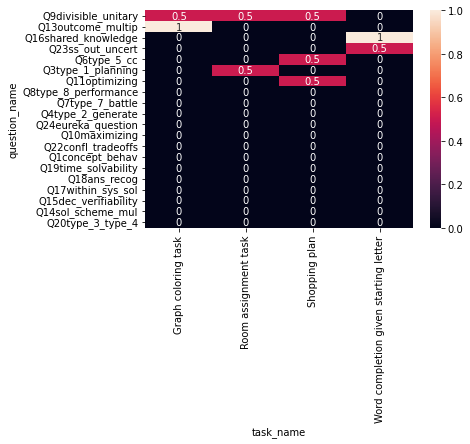

In [ ]:
modal_filtered_results_diff = modal_filtered_results-ground_truth
modal_filtered_results_diff = modal_filtered_results_diff.assign(sum=abs(modal_filtered_results_diff).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1]
modal_filtered_results_diff = modal_filtered_results_diff[modal_filtered_results_diff.sum(0).sort_values(ascending=False).index]
sns.heatmap(abs(modal_filtered_results_diff), annot=True, vmin = 0, vmax = 1)

<AxesSubplot:xlabel='None-task_name', ylabel='question_name'>

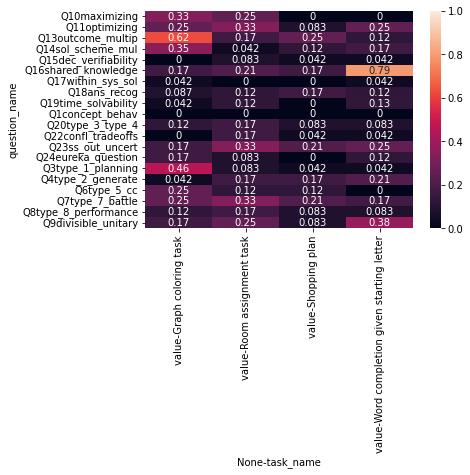

In [ ]:
df_karger_filtered_recoded = df_karger_filtered.replace(-1, 0)
mean_filtered_results = df_karger_filtered_recoded.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mean Version
mean_filtered_results = mean_filtered_results.pivot(index = "question_name", columns = "task_name")

sns.heatmap(abs(mean_filtered_results-ground_truth_mean), annot=True, vmin = 0, vmax = 1)


In [ ]:
np.sum(np.asmatrix(abs(mean_filtered_results-ground_truth_mean)))

11.780797101449277

### boostrap a baseline

In [ ]:
# get a bootstrapped baseline
baseline_dropped_dicts = [{}, {}, {}, {}]
upper_bounds = [[],[],[],[]]
lower_bounds = [[],[],[],[]]

# mturk data
for i in range(1,49):
  diffs = [[],[],[],[]]
  for j in range(100): # do this 100 times to bootstrap
    sampled_names = random.sample(list(df_karger["name"].unique()), i)
    data_samples = df_karger[df_karger["name"].isin(sampled_names)]
    data_samples = data_samples.replace(-1, 0)
    mean_filtered_results = data_samples.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mean Version
    mean_filtered_results = mean_filtered_results.pivot(index = "question_name", columns = "task_name")

    filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"],mean_filtered_results["value"]["Graph coloring task"], mean_filtered_results["value"]["Shopping plan"]]
    ground_truths = [ground_truth_mean["Word completion given starting letter"],ground_truth_mean["Room assignment task"],ground_truth_mean["Graph coloring task"],ground_truth_mean["Shopping plan"]]

    for k in range(len(ground_truths)):
      diff = np.sum(np.asmatrix(abs(filtered_results[k]-ground_truths[k])))
      diffs[k].append(diff)
    
  for k in range(len(ground_truths)):
    diff = np.sum(np.asmatrix(abs(filtered_results[k]-ground_truths[k])))
    baseline_dropped_dicts[k][i] = np.mean(diffs[k])
    upper_bounds[k].append(abs(np.mean(diffs[k])-np.percentile(diffs[k], 0.025)))
    lower_bounds[k].append(abs(np.mean(diffs[k])-np.percentile(diffs[k], .975)))

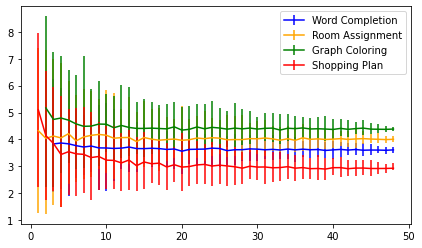

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(x = range(1,49), y=list(baseline_dropped_dicts[0].values()), yerr=[lower_bounds[0], upper_bounds[0]], label = "Word Completion", color = "blue")
ax.errorbar(x = range(1,49), y=list(baseline_dropped_dicts[1].values()), yerr=[lower_bounds[1], upper_bounds[1]], label = "Room Assignment", color = "orange")
ax.errorbar(x = range(1,49), y=list(baseline_dropped_dicts[2].values()), yerr=[lower_bounds[2], upper_bounds[2]], label = "Graph Coloring", color = "green")
ax.errorbar(x = range(1,49), y=list(baseline_dropped_dicts[3].values()), yerr=[lower_bounds[3], upper_bounds[3]], label = "Shopping Plan", color = "red")

plt.legend()

### How do you get the lowest sum?

In [ ]:
def get_filtered_results(workers_past_thresh):
    df_karger_filtered = df_karger[df_karger['name'].isin(workers_past_thresh)]
    df_karger_filtered_recoded = df_karger_filtered.replace(-1, 0)
    mean_filtered_results = df_karger_filtered_recoded.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mean Version
    mean_filtered_results = mean_filtered_results.pivot(index = "question_name", columns = "task_name")

    return(mean_filtered_results)

In [ ]:
num_questions = 20

#### Shopping Plan

In [ ]:
# set it up so that we can explore score cutoff points rather than numeric cutoff points
worker_dict_shopping = {k: ((num_questions-v) / num_questions) for total in (sum(worker_dict_shopping.values()),) for k, v in worker_dict_shopping.items()}
max = np.max(list(worker_dict_shopping.values()))
min = np.min(list(worker_dict_shopping.values()))

In [ ]:
dropped_dicts = [{}, {}, {}]
thresh_lb = [[],[],[]]
thresh_ub = [[],[],[]]
num_workers = []

for n in np.arange(min, max+0.01, 0.01):
    #worst_workers = list(dict(sorted(worker_dict_shopping.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
    #df_karger_filtered = df_karger[~df_karger['name'].isin(worst_workers)]
    workers_past_thresh = list(dict((k, v) for k, v in worker_dict_shopping.items() if v >= n).keys())

    if(len(workers_past_thresh) > 0):

        num_workers.append(len(workers_past_thresh))
        # implement a little bit o' bootstrapping here
        # what if we randomly picked half of the people who got the same score?
        thresh_sample = [[],[],[]]
        for boot_iter in range(100):
            # sample half the workers
            worker_sample_size = math.ceil(0.5*len(workers_past_thresh))
            workers_past_thresh_sampled = random.sample(workers_past_thresh, worker_sample_size)
            mean_filtered_results = get_filtered_results(workers_past_thresh_sampled)

            filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Graph coloring task"]]
            ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"],ground_truth_mean["Graph coloring task"]]

            for j in range(len(ground_truths)):
                diff = np.sum(np.asmatrix(abs(filtered_results[j]-ground_truths[j])))
                thresh_sample[j].append(diff)
       
        mean_filtered_results = get_filtered_results(workers_past_thresh)
        # get values for each task individually
        filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Graph coloring task"]]
        ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"],ground_truth_mean["Graph coloring task"]]

        for i in range(len(ground_truths)):
            diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
            dropped_dicts[i][n] = diff
            thresh_lb[i].append(abs(diff-np.percentile(thresh_sample[i], 0.025)))
            thresh_ub[i].append(abs(diff-np.percentile(thresh_sample[i], .975)))
            

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Shopping plan)')

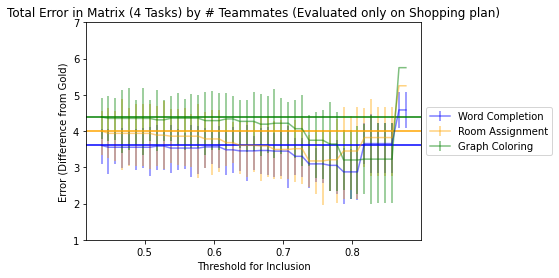

In [ ]:
# selection based on task performance
plt.errorbar(dropped_dicts[0].keys(),dropped_dicts[0].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Word Completion", color = 'blue', alpha = 0.5)
plt.errorbar(dropped_dicts[1].keys(),dropped_dicts[1].values(), yerr=[thresh_lb[1], thresh_ub[1]], label = "Room Assignment", color = 'orange', alpha = 0.5)
plt.errorbar(dropped_dicts[2].keys(),dropped_dicts[2].values(), yerr=[thresh_lb[2], thresh_ub[2]], label = "Graph Coloring", color = 'green', alpha = 0.5)

#means
plt.axhline(y=list(dropped_dicts[0].values())[0], color='blue', linestyle='-')
plt.axhline(y=list(dropped_dicts[1].values())[0], color='orange', linestyle='-')
plt.axhline(y=list(dropped_dicts[2].values())[0], color='green', linestyle='-')

plt.ylim([1, 7])
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Error (Difference from Gold)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Shopping plan)")

# annotate
# for i, label in enumerate(num_workers):
#     plt.annotate(label, xy = (list(dropped_dicts[0].keys())[i], 6))


Text(0.5, 1.0, '% Workers Per Threshold --- Evaluated on Shopping Plan')

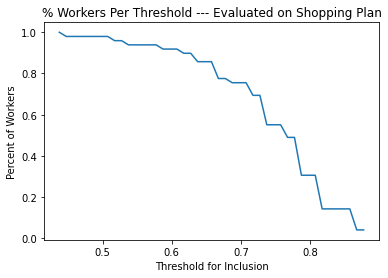

In [ ]:
# Plot the ECDF
prob_thresh =dropped_dicts[0].keys()
worker_pct = np.divide(num_workers, len(df_karger["name"].unique()))
plt.plot(prob_thresh,worker_pct)
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Percent of Workers")
plt.title("% Workers Per Threshold --- Evaluated on Shopping Plan")

In [ ]:
num_teammates = list(range(1,49))
num_teammates.reverse()

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Shopping plan)')

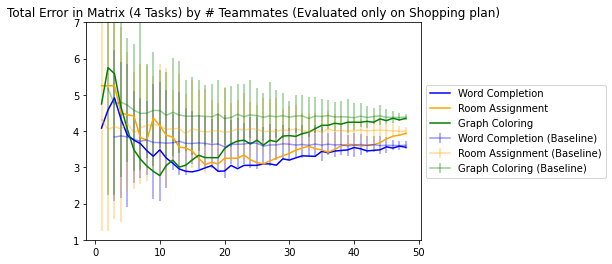

In [ ]:
# commented out for now --- due to shifting to look at thresholds

# # baselines
# plt.errorbar(x = baseline_dropped_dicts[0].keys(), y=baseline_dropped_dicts[0].values(), yerr=[lower_bounds[0], upper_bounds[0]], label = "Word Completion (Baseline)", color = "blue", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[1].keys(), y=baseline_dropped_dicts[1].values(), yerr=[lower_bounds[1], upper_bounds[1]], label = "Room Assignment (Baseline)", color = "orange", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[2].keys(), y=baseline_dropped_dicts[2].values(), yerr=[lower_bounds[2], upper_bounds[2]], label = "Graph Coloring (Baseline)", color = "green", alpha = 0.4)

# # selection based on task performance
# plt.plot(num_teammates,dropped_dicts[0].values(), label = "Word Completion", color = 'blue')
# plt.plot(num_teammates,dropped_dicts[1].values(), label = "Room Assignment", color = 'orange')
# plt.plot(num_teammates,dropped_dicts[2].values(), label = "Graph Coloring", color = 'green')

# plt.ylim([1, 7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Shopping plan)")

#### Word Completion

In [ ]:
# set it up so that we can explore score cutoff points rather than numeric cutoff points
worker_dict_word = {k: ((num_questions-v) / num_questions) for total in (sum(worker_dict_word.values()),) for k, v in worker_dict_word.items()}
max = np.max(list(worker_dict_word.values()))
min = np.min(list(worker_dict_word.values()))

In [ ]:
dropped_dicts = [{}, {}, {}]
thresh_lb = [[],[],[]]
thresh_ub = [[],[],[]]
num_workers = []

for n in np.arange(min, max+0.01, 0.01):
    #worst_workers = list(dict(sorted(worker_dict_word.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
    #df_karger_filtered = df_karger[~df_karger['name'].isin(worst_workers)]

    workers_past_thresh = list(dict((k, v) for k, v in worker_dict_word.items() if v >= n).keys())

    if(len(workers_past_thresh) > 0):
        num_workers.append(len(workers_past_thresh))
        # implement a little bit o' bootstrapping here
        # what if we randomly picked half of the people who got the same score?
        thresh_sample = [[],[],[]]
        for boot_iter in range(100):
            # sample half the workers
            worker_sample_size = math.ceil(0.5*len(workers_past_thresh))
            workers_past_thresh_sampled = random.sample(workers_past_thresh, worker_sample_size)
            mean_filtered_results = get_filtered_results(workers_past_thresh_sampled)

            filtered_results = [mean_filtered_results["value"]["Shopping plan"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Graph coloring task"]]
            ground_truths = [ground_truth_mean["Shopping plan"], ground_truth_mean["Room assignment task"],ground_truth_mean["Graph coloring task"]]

            for j in range(len(ground_truths)):
                diff = np.sum(np.asmatrix(abs(filtered_results[j]-ground_truths[j])))
                thresh_sample[j].append(diff)
       
        mean_filtered_results = get_filtered_results(workers_past_thresh)
        
        # get values for each task individually
        filtered_results = [mean_filtered_results["value"]["Shopping plan"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Graph coloring task"]]
        ground_truths = [ground_truth_mean["Shopping plan"], ground_truth_mean["Room assignment task"],ground_truth_mean["Graph coloring task"]]

        for i in range(len(ground_truths)):
            diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
            dropped_dicts[i][n] = diff
            thresh_lb[i].append(abs(diff-np.percentile(thresh_sample[i], 0.025)))
            thresh_ub[i].append(abs(diff-np.percentile(thresh_sample[i], .975)))

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Word Completion)')

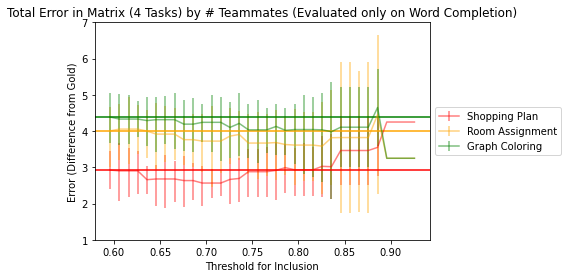

In [ ]:
# selection based on task performance
plt.errorbar(dropped_dicts[0].keys(),dropped_dicts[0].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Shopping Plan", color = 'red', alpha = 0.5)
plt.errorbar(dropped_dicts[1].keys(),dropped_dicts[1].values(), yerr=[thresh_lb[1], thresh_ub[1]], label = "Room Assignment", color = 'orange', alpha = 0.5)
plt.errorbar(dropped_dicts[2].keys(),dropped_dicts[2].values(), yerr=[thresh_lb[2], thresh_ub[2]], label = "Graph Coloring", color = 'green', alpha = 0.5)

#means
plt.axhline(y=list(dropped_dicts[0].values())[0], color='red', linestyle='-')
plt.axhline(y=list(dropped_dicts[1].values())[0], color='orange', linestyle='-')
plt.axhline(y=list(dropped_dicts[2].values())[0], color='green', linestyle='-')

plt.ylim([1, 7])
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Error (Difference from Gold)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Word Completion)")

# annotate
# for i, label in enumerate(num_workers):
#     plt.annotate(label, xy = (list(dropped_dicts[0].keys())[i], 6))

Text(0.5, 1.0, '% Workers Per Threshold --- Evaluated on Word Completion')

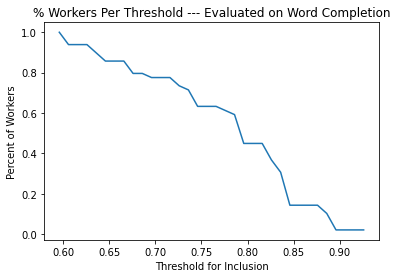

In [ ]:
# Plot the ECDF
prob_thresh =dropped_dicts[0].keys()
worker_pct = np.divide(num_workers, len(df_karger["name"].unique()))
plt.plot(prob_thresh,worker_pct)
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Percent of Workers")
plt.title("% Workers Per Threshold --- Evaluated on Word Completion")

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Word Completion)')

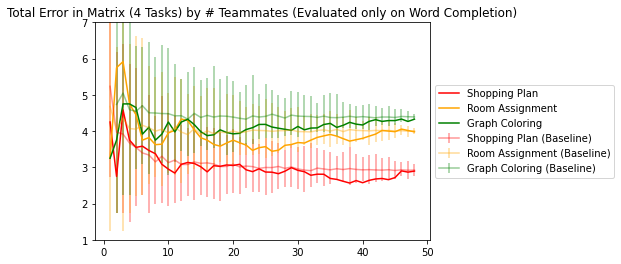

In [ ]:
# commented out for now --- due to shifting to look at thresholds

# # baselines
# plt.errorbar(x = baseline_dropped_dicts[3].keys(), y=baseline_dropped_dicts[3].values(), yerr=[lower_bounds[3], upper_bounds[3]], label = "Shopping Plan (Baseline)", color = "red", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[1].keys(), y=baseline_dropped_dicts[1].values(), yerr=[lower_bounds[1], upper_bounds[1]], label = "Room Assignment (Baseline)", color = "orange", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[2].keys(), y=baseline_dropped_dicts[2].values(), yerr=[lower_bounds[2], upper_bounds[2]], label = "Graph Coloring (Baseline)", color = "green", alpha = 0.4)

# # selection based on task performance
# plt.plot(num_teammates,dropped_dicts[0].values(), label = "Shopping Plan", color = 'red')
# plt.plot(num_teammates,dropped_dicts[1].values(), label = "Room Assignment", color = 'orange')
# plt.plot(num_teammates,dropped_dicts[2].values(), label = "Graph Coloring", color = 'green')

# plt.ylim([1, 7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Word Completion)")

#### Room Assignment

In [ ]:
# set it up so that we can explore score cutoff points rather than numeric cutoff points
worker_dict_room = {k: ((num_questions-v) / num_questions) for total in (sum(worker_dict_room.values()),) for k, v in worker_dict_room.items()}
max = np.max(list(worker_dict_room.values()))
min = np.min(list(worker_dict_room.values()))

In [ ]:
dropped_dicts = [{}, {}, {}]
thresh_lb = [[],[],[]]
thresh_ub = [[],[],[]]
num_workers = []

for n in np.arange(min, max+0.01, 0.01):
    #worst_workers = list(dict(sorted(worker_dict_room.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
    #df_karger_filtered = df_karger[~df_karger['name'].isin(worst_workers)]

    workers_past_thresh = list(dict((k, v) for k, v in worker_dict_room.items() if v >= n).keys())

    if(len(workers_past_thresh) > 0):
        num_workers.append(len(workers_past_thresh))
        # implement a little bit o' bootstrapping here
        # what if we randomly picked half of the people who got the same score?
        thresh_sample = [[],[],[]]
        for boot_iter in range(100):
            # sample half the workers
            worker_sample_size = math.ceil(0.5*len(workers_past_thresh))
            workers_past_thresh_sampled = random.sample(workers_past_thresh, worker_sample_size)
            mean_filtered_results = get_filtered_results(workers_past_thresh_sampled)

            filtered_results = [mean_filtered_results["value"]["Shopping plan"], mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Graph coloring task"]]
            ground_truths = [ground_truth_mean["Shopping plan"], ground_truth_mean["Word completion given starting letter"],ground_truth_mean["Graph coloring task"]]

            for j in range(len(ground_truths)):
                diff = np.sum(np.asmatrix(abs(filtered_results[j]-ground_truths[j])))
                thresh_sample[j].append(diff)
       
        mean_filtered_results = get_filtered_results(workers_past_thresh)

        # get values for each task individually
        filtered_results = [mean_filtered_results["value"]["Shopping plan"], mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Graph coloring task"]]
        ground_truths = [ground_truth_mean["Shopping plan"], ground_truth_mean["Word completion given starting letter"],ground_truth_mean["Graph coloring task"]]

        for i in range(len(ground_truths)):
            diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
            dropped_dicts[i][n] = diff
            thresh_lb[i].append(abs(diff-np.percentile(thresh_sample[i], 0.025)))
            thresh_ub[i].append(abs(diff-np.percentile(thresh_sample[i], .975)))

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Room Assignment)')

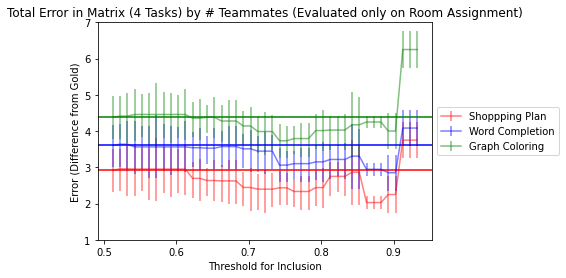

In [ ]:
# selection based on task performance
plt.errorbar(dropped_dicts[0].keys(),dropped_dicts[0].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Shoppping Plan", color = 'red', alpha = 0.5)
plt.errorbar(dropped_dicts[1].keys(),dropped_dicts[1].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Word Completion", color = 'blue', alpha = 0.5)
plt.errorbar(dropped_dicts[2].keys(),dropped_dicts[2].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Graph Coloring", color = 'green', alpha = 0.5)

#means
plt.axhline(y=list(dropped_dicts[0].values())[0], color='red', linestyle='-')
plt.axhline(y=list(dropped_dicts[1].values())[0], color='blue', linestyle='-')
plt.axhline(y=list(dropped_dicts[2].values())[0], color='green', linestyle='-')

plt.ylim([1, 7])
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Error (Difference from Gold)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Room Assignment)")

# annotate
# for i, label in enumerate(num_workers):
#     plt.annotate(label, xy = (list(dropped_dicts[0].keys())[i], 6))

Text(0.5, 1.0, '% Workers Per Threshold --- Evaluated on Room Assignment')

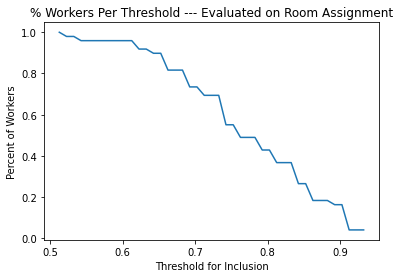

In [ ]:
# Plot the ECDF
prob_thresh =dropped_dicts[0].keys()
worker_pct = np.divide(num_workers, len(df_karger["name"].unique()))
plt.plot(prob_thresh,worker_pct)
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Percent of Workers")
plt.title("% Workers Per Threshold --- Evaluated on Room Assignment")

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Room Assignment Task)')

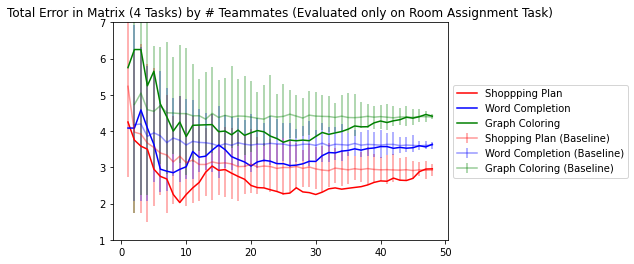

In [ ]:
# # baselines
# plt.errorbar(x = baseline_dropped_dicts[3].keys(), y=baseline_dropped_dicts[3].values(), yerr=[lower_bounds[3], upper_bounds[3]], label = "Shopping Plan (Baseline)", color = "red", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[0].keys(), y=baseline_dropped_dicts[0].values(), yerr=[lower_bounds[0], upper_bounds[0]], label = "Word Completion (Baseline)", color = "blue", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[2].keys(), y=baseline_dropped_dicts[2].values(), yerr=[lower_bounds[2], upper_bounds[2]], label = "Graph Coloring (Baseline)", color = "green", alpha = 0.4)

# # selection based on task performance
# plt.plot(num_teammates,dropped_dicts[0].values(), label = "Shoppping Plan", color = 'red')
# plt.plot(num_teammates,dropped_dicts[1].values(), label = "Word Completion", color = 'blue')
# plt.plot(num_teammates,dropped_dicts[2].values(), label = "Graph Coloring", color = 'green')
# #

# plt.ylim([1, 7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Room Assignment Task)")

#### Graph Coloring

In [ ]:
# set it up so that we can explore score cutoff points rather than numeric cutoff points
worker_dict_graph = {k: ((num_questions-v) / num_questions) for total in (sum(worker_dict_graph.values()),) for k, v in worker_dict_graph.items()}
max = np.max(list(worker_dict_graph.values()))
min = np.min(list(worker_dict_graph.values()))

In [ ]:
dropped_dicts = [{}, {}, {}]
thresh_lb = [[],[],[]]
thresh_ub = [[],[],[]]
num_workers = []

for n in np.arange(min, max+0.01, 0.01):
    #worst_workers = list(dict(sorted(worker_dict_graph.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
    #df_karger_filtered = df_karger[~df_karger['name'].isin(worst_workers)]

    workers_past_thresh = list(dict((k, v) for k, v in worker_dict_graph.items() if v >= n).keys())

    if(len(workers_past_thresh) > 0):
        num_workers.append(len(workers_past_thresh))
        # implement a little bit o' bootstrapping here
        # what if we randomly picked half of the people who got the same score?
        thresh_sample = [[],[],[]]
        for boot_iter in range(100):
            # sample half the workers
            worker_sample_size = math.ceil(0.5*len(workers_past_thresh))
            workers_past_thresh_sampled = random.sample(workers_past_thresh, worker_sample_size)
            mean_filtered_results = get_filtered_results(workers_past_thresh_sampled)

            filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Shopping plan"]]
            ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"],ground_truth_mean["Shopping plan"]]

            for j in range(len(ground_truths)):
                diff = np.sum(np.asmatrix(abs(filtered_results[j]-ground_truths[j])))
                thresh_sample[j].append(diff)
       
        mean_filtered_results = get_filtered_results(workers_past_thresh)
        # get values for each task individually
        filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"], mean_filtered_results["value"]["Shopping plan"]]
        ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"],ground_truth_mean["Shopping plan"]]

        for i in range(len(ground_truths)):
            diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
            dropped_dicts[i][n] = diff
            thresh_lb[i].append(abs(diff-np.percentile(thresh_sample[i], 0.025)))
            thresh_ub[i].append(abs(diff-np.percentile(thresh_sample[i], .975)))

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Graph Coloring)')

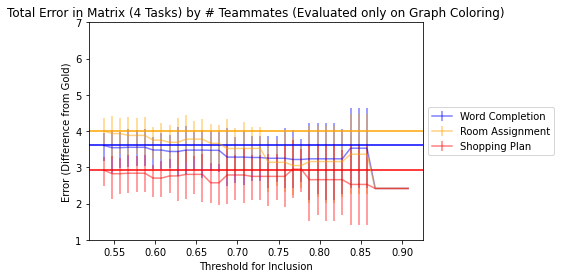

In [ ]:
# selection based on task performance
plt.errorbar(dropped_dicts[0].keys(),dropped_dicts[0].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Word Completion", color = 'blue', alpha = 0.5)
plt.errorbar(dropped_dicts[1].keys(),dropped_dicts[1].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Room Assignment", color = 'orange', alpha = 0.5)
plt.errorbar(dropped_dicts[2].keys(),dropped_dicts[2].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Shopping Plan", color = 'red', alpha = 0.5)

#means
plt.axhline(y=list(dropped_dicts[0].values())[0], color='blue', linestyle='-')
plt.axhline(y=list(dropped_dicts[1].values())[0], color='orange', linestyle='-')
plt.axhline(y=list(dropped_dicts[2].values())[0], color='red', linestyle='-')

plt.ylim([1, 7])
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Error (Difference from Gold)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Graph Coloring)")

# # annotate
# for i, label in enumerate(num_workers):
#     plt.annotate(label, xy = (list(dropped_dicts[0].keys())[i], 6))

Text(0.5, 1.0, '% Workers Per Threshold --- Evaluated on Graph Coloring')

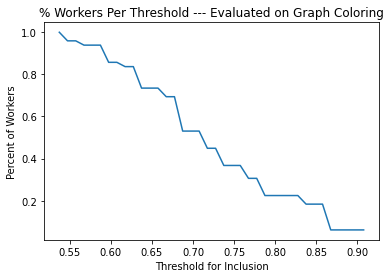

In [ ]:
# Plot the ECDF
prob_thresh =dropped_dicts[0].keys()
worker_pct = np.divide(num_workers, len(df_karger["name"].unique()))
plt.plot(prob_thresh,worker_pct)
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Percent of Workers")
plt.title("% Workers Per Threshold --- Evaluated on Graph Coloring")

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Graph Coloring Task)')

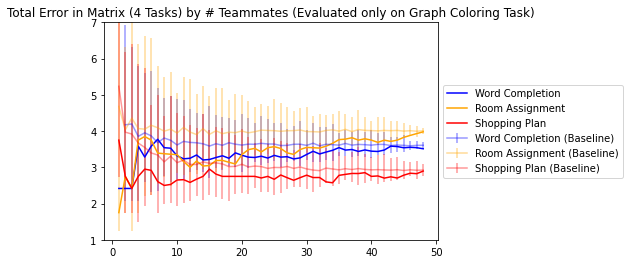

In [ ]:
# # baselines
# plt.errorbar(x = baseline_dropped_dicts[0].keys(), y=baseline_dropped_dicts[0].values(), yerr=[lower_bounds[0], upper_bounds[0]], label = "Word Completion (Baseline)", color = "blue", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[1].keys(), y=baseline_dropped_dicts[1].values(), yerr=[lower_bounds[1], upper_bounds[1]], label = "Room Assignment (Baseline)", color = "orange", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[3].keys(), y=baseline_dropped_dicts[3].values(), yerr=[lower_bounds[3], upper_bounds[3]], label = "Shopping Plan (Baseline)", color = "red", alpha = 0.4)

# # selection based on task performance
# plt.plot(num_teammates,dropped_dicts[0].values(), label = "Word Completion", color = 'blue')
# plt.plot(num_teammates,dropped_dicts[1].values(), label = "Room Assignment", color = 'orange')
# plt.plot(num_teammates,dropped_dicts[2].values(), label = "Shopping Plan", color = 'red')

# plt.ylim([1, 7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated only on Graph Coloring Task)")

### What's the optimal pre-quiz?
Investigate whether taking the harder half of each question is more informative

In [ ]:
#first_half_questions = ["Q10maximizing","Q11optimizing","Q13outcome_multip","Q14sol_scheme_mul","Q15dec_verifiability","Q16shared_knowledge","Q17within_sys_sol","Q18ans_recog","Q19time_solvability","Q1concept_behav"]
#second_half_questions = ["Q20type3_type_4","Q22confl_tradeoffs","Q23ss_out_uncert","Q24eureka_question","Q3type_1_planning","Q4type_2_generate","Q6type_5_cc","Q7type_7_battle","Q8type_8_performance","Q9divisible_unitary"]

In [ ]:
def select_split_question_subsets():
    questions = list(set(df_karger["question_name"].unique())-{"Q9divisible_unitary"}) # question has 0.5 on the gold

    # questions from graph coloring
    graph_questions = random.sample(list(set(questions)-{"Q22confl_tradeoffs"}),8)

    # questions from shopping
    shopping_questions = random.sample(list(set(questions)-set(graph_questions)-{"Q11optimizing", "Q6type_5_cc"}), 8)

    shop_second_half = df_karger_shopping_only[df_karger_shopping_only['question_name'].isin(shopping_questions)]
    graph_first_half = df_karger_graph_only[df_karger_graph_only['question_name'].isin(graph_questions)]
    return((shop_second_half.append(graph_first_half),graph_questions,shopping_questions))

In [ ]:
# Split up these questions for evaluation purposes
df_shopping_and_graph = df_karger[(df_karger["task_name"] == "Shopping plan") | (df_karger["task_name"] == "Graph coloring task")]
df_room_and_word = df_karger[(df_karger["task_name"] == "Room assignment task") | (df_karger["task_name"] == "Word completion given starting letter")]

In [ ]:
random.seed(100)

# keep track of the question names and lowest error ratess
diffs_keeping_10 = []
diffs_keeping_20 = []
diffs_shopping_qnames = []
diffs_graph_qnames = []

for i in range(1000):
    # select a random split -- half from Shopping Plan and half from Graph Coloring
    question_subsets = select_split_question_subsets()
    df_merged_task_halves = question_subsets[0]
    
    # populate the worker dictionary -- how well did workers do according to this standard?
    worker_dict_mixed = {}
    for name in df_karger["name"].unique():
        df_for_name = df_merged_task_halves[df_merged_task_halves["name"]==name]
        df_for_name_pivoted = df_for_name.pivot_table(index = "question_name", columns = "task_name", values = "value").replace(-1, 0)
        diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
        worker_dict_mixed[name] = diff_from_gold

    n1 = 10 # fix this at 10 and 20 best workers
    n2 = 20 

    # Evaluate on Room Assignment and Word Completion
    best_workers10 = list(dict(sorted(worker_dict_mixed.items(), key=lambda x:x[1])[0:n1]).keys())
    df_karger_filtered10 = df_room_and_word[df_room_and_word['name'].isin(best_workers10)].replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
    best_workers20 = list(dict(sorted(worker_dict_mixed.items(), key=lambda x:x[1])[0:n2]).keys())
    df_karger_filtered20 = df_room_and_word[df_room_and_word['name'].isin(best_workers20)].replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")

    diff_from_gold10 = np.nansum(abs(np.asmatrix(df_karger_filtered10-ground_truth_mean)))
    diff_from_gold20 = np.nansum(abs(np.asmatrix(df_karger_filtered20-ground_truth_mean)))

    diffs_keeping_10.append(diff_from_gold10)
    diffs_keeping_20.append(diff_from_gold20)
    diffs_graph_qnames.append(question_subsets[1])
    diffs_shopping_qnames.append(question_subsets[2])


In [ ]:
# get min error of choosing 10 people
np.min(diffs_keeping_10)

5.033333333333333

In [ ]:
# get min error of choosing 20 people
np.min(diffs_keeping_20)

5.449122807017544

In [ ]:
# comparison to the baseline
ten_person_baseline  = baseline_dropped_dicts[0][10] + baseline_dropped_dicts[1][10] 
ten_person_lb = lower_bounds[0][10] + lower_bounds[1][10]

# comparison to the baseline
twenty_person_baseline = baseline_dropped_dicts[0][20] + baseline_dropped_dicts[1][20]
twenty_person_lb = lower_bounds[0][20] + lower_bounds[1][20]

In [ ]:
# mean and lower bound of choosing 10 random people
print(ten_person_baseline)
print(ten_person_lb)

# mean and lower bound of choosing 20 random people
print(twenty_person_baseline)
print(twenty_person_lb)

7.83825
2.755827272727271
7.530222222222221
1.2936012531328323


In [ ]:
min_index_10 = diffs_keeping_10.index(np.min(diffs_keeping_10))
print(diffs_shopping_qnames[min_index_10])
print(diffs_graph_qnames[min_index_10])

['Q18ans_recog', 'Q24eureka_question', 'Q17within_sys_sol', 'Q7type_7_battle', 'Q23ss_out_uncert', 'Q15dec_verifiability', 'Q8type_8_performance', 'Q14sol_scheme_mul']
['Q16shared_knowledge', 'Q13outcome_multip', 'Q4type_2_generate', 'Q11optimizing', 'Q6type_5_cc', 'Q3type_1_planning', 'Q20type_3_type_4', 'Q1concept_behav']


In [ ]:
min_index_20 = diffs_keeping_20.index(np.min(diffs_keeping_20))
print(diffs_shopping_qnames[min_index_20])
print(diffs_graph_qnames[min_index_20])

['Q3type_1_planning', 'Q19time_solvability', 'Q7type_7_battle', 'Q10maximizing', 'Q18ans_recog', 'Q22confl_tradeoffs', 'Q20type_3_type_4', 'Q23ss_out_uncert']
['Q14sol_scheme_mul', 'Q24eureka_question', 'Q4type_2_generate', 'Q11optimizing', 'Q15dec_verifiability', 'Q8type_8_performance', 'Q16shared_knowledge', 'Q17within_sys_sol']


In [ ]:
diffs_keeping_20[min_index_10] # with the min 10 questions, what do we get when we select 20?

6.633333333333333

In [ ]:
diffs_keeping_10[min_index_20] # with the min 20 questions, what do we get when we select 10?

5.066666666666666

In [ ]:
# compare to evaluating on all of shopping plan + graph coloring
worker_dict_both= {}

for name in df_karger["name"].unique():
    df_for_name = df_shopping_and_graph[df_shopping_and_graph["name"]==name]
    df_for_name_pivoted = df_for_name.pivot_table(index = "question_name", columns = "task_name", values = "value").replace(-1, 0)
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_both[name] = diff_from_gold

n1 = 10 # fix this at 10 and 20 best workers
n2 = 20 
best_workers10 = list(dict(sorted(worker_dict_both.items(), key=lambda x:x[1])[0:n1]).keys())
df_karger_filtered10 = df_room_and_word[df_room_and_word['name'].isin(best_workers10)].replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")
best_workers20 = list(dict(sorted(worker_dict_both.items(), key=lambda x:x[1])[0:n2]).keys())
df_karger_filtered20 = df_room_and_word[df_room_and_word['name'].isin(best_workers20)].replace(-1, 0).pivot_table(index = "question_name", columns = "task_name", values = "value")

diff_from_gold10 = np.nansum(abs(np.asmatrix(df_karger_filtered10-ground_truth_mean)))
print(diff_from_gold10)
diff_from_gold20 = np.nansum(abs(np.asmatrix(df_karger_filtered20-ground_truth_mean)))
print(diff_from_gold20)

5.966666666666667
6.383333333333334


#### Plotting Results of Evaluating on Randomly-Chosen Questions

In [ ]:
# dropped_dicts = [{}, {}]

# for n in range(1,49):
#     worst_workers = list(dict(sorted(worker_dict_mixed.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
#     df_karger_filtered = df_karger[~df_karger['name'].isin(worst_workers)]

#     df_karger_filtered_recoded = df_karger_filtered.replace(-1, 0)
#     mean_filtered_results = df_karger_filtered_recoded.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mean Version
#     mean_filtered_results = mean_filtered_results.pivot(index = "question_name", columns = "task_name")

#     # get values for each task individually
#     filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"]]
#     ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"]]

#     for i in range(len(ground_truths)):
#         diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
#         dropped_dicts[i][n] = diff

In [ ]:
# Set up the worker dict
shop_second_half = df_karger_shopping_only[df_karger_shopping_only['question_name'].isin(diffs_shopping_qnames[min_index_20])]
graph_first_half = df_karger_graph_only[df_karger_graph_only['question_name'].isin(diffs_graph_qnames[min_index_20])]
df_merged_task_halves = shop_second_half.append(graph_first_half)

worker_dict_mixed = {}
for name in df_karger["name"].unique():
    df_for_name = df_merged_task_halves[df_merged_task_halves["name"]==name]
    df_for_name_pivoted = df_for_name.pivot_table(index = "question_name", columns = "task_name", values = "value").replace(-1, 0)
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-ground_truth_mean)))
    worker_dict_mixed[name] = diff_from_gold

In [ ]:
# set it up so that we can explore score cutoff points rather than numeric cutoff points
worker_dict_mixed = {k: ((num_questions-v) / num_questions) for total in (sum(worker_dict_mixed.values()),) for k, v in worker_dict_mixed.items()}
max = np.max(list(worker_dict_graph.values()))
min = np.min(list(worker_dict_graph.values()))

In [ ]:
### Look at what threshold we need on the quiz in order to get the optimum
dropped_dicts = [{}, {}]
thresh_lb = [[],[]]
thresh_ub = [[],[]]
num_workers = []

for n in np.arange(min, max+0.01, 0.01):
    workers_past_thresh = list(dict((k, v) for k, v in worker_dict_mixed.items() if v >= n).keys())

    if(len(workers_past_thresh) > 0):
        num_workers.append(len(workers_past_thresh))
        # implement a little bit o' bootstrapping here
        # what if we randomly picked half of the people who got the same score?
        thresh_sample = [[],[],[]]
        for boot_iter in range(100):
            # sample half the workers
            worker_sample_size = math.ceil(0.5*len(workers_past_thresh))
            workers_past_thresh_sampled = random.sample(workers_past_thresh, worker_sample_size)
            mean_filtered_results = get_filtered_results(workers_past_thresh_sampled)

            filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"]]
            ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"]]

            for j in range(len(ground_truths)):
                diff = np.sum(np.asmatrix(abs(filtered_results[j]-ground_truths[j])))
                thresh_sample[j].append(diff)
       
        mean_filtered_results = get_filtered_results(workers_past_thresh)
        # get values for each task individually
        filtered_results = [mean_filtered_results["value"]["Word completion given starting letter"], mean_filtered_results["value"]["Room assignment task"]]
        ground_truths = [ground_truth_mean["Word completion given starting letter"], ground_truth_mean["Room assignment task"]]

        for i in range(len(ground_truths)):
            diff = np.sum(np.asmatrix(abs(filtered_results[i]-ground_truths[i])))
            dropped_dicts[i][n] = diff
            thresh_lb[i].append(abs(diff-np.percentile(thresh_sample[i], 0.025)))
            thresh_ub[i].append(abs(diff-np.percentile(thresh_sample[i], .975)))

Text(0.5, 1.0, 'Total Error in Matrix (4 Tasks) by # Teammates (Evaluated on Optimal Questions)')

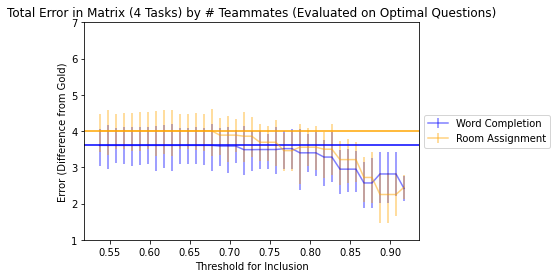

In [ ]:
# selection based on task performance
plt.errorbar(dropped_dicts[0].keys(),dropped_dicts[0].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Word Completion", color = 'blue', alpha = 0.5)
plt.errorbar(dropped_dicts[1].keys(),dropped_dicts[1].values(), yerr=[thresh_lb[0], thresh_ub[0]], label = "Room Assignment", color = 'orange', alpha = 0.5)
#means
plt.axhline(y=list(dropped_dicts[0].values())[0], color='blue', linestyle='-')
plt.axhline(y=list(dropped_dicts[1].values())[0], color='orange', linestyle='-')

plt.ylim([1, 7])
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Error (Difference from Gold)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total Error in Matrix (4 Tasks) by # Teammates (Evaluated on Optimal Questions)")

Text(0.5, 1.0, '% Workers Per Threshold --- Evaluated on Optimal Questions')

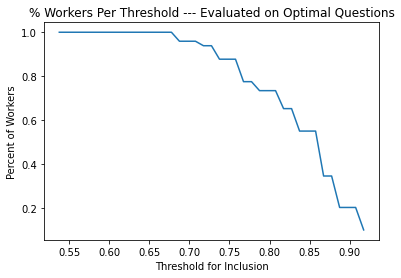

In [ ]:
# Plot the ECDF
prob_thresh =dropped_dicts[0].keys()
worker_pct = np.divide(num_workers, len(df_karger["name"].unique()))
plt.plot(prob_thresh,worker_pct)
plt.xlabel("Threshold for Inclusion")
plt.ylabel("Percent of Workers")
plt.title("% Workers Per Threshold --- Evaluated on Optimal Questions")

Text(0.5, 1.0, 'Total Error in Matrix by # Teammates (Evaluated only on 1/2 Graph Coloring Task + 1/2 Shopping Plan)')

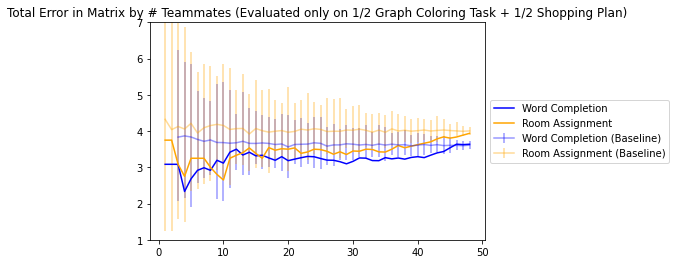

In [ ]:
# # baselines
# plt.errorbar(x = baseline_dropped_dicts[0].keys(), y=baseline_dropped_dicts[0].values(), yerr=[lower_bounds[0], upper_bounds[0]], label = "Word Completion (Baseline)", color = "blue", alpha = 0.4)
# plt.errorbar(x = baseline_dropped_dicts[1].keys(), y=baseline_dropped_dicts[1].values(), yerr=[lower_bounds[1], upper_bounds[1]], label = "Room Assignment (Baseline)", color = "orange", alpha = 0.4)
# # selection based on task performance
# plt.plot(num_teammates,dropped_dicts[0].values(), label = "Word Completion", color = 'blue')
# plt.plot(num_teammates,dropped_dicts[1].values(), label = "Room Assignment", color = 'orange')

# plt.ylim([1, 7])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Total Error in Matrix by # Teammates (Evaluated only on 1/2 Graph Coloring Task + 1/2 Shopping Plan)")

### Can we do the evaluation on the actual questions included in the quiz?

In [ ]:
# get the ground truth for everything else
truth_raw = ground_truth_csv.loc[(ground_truth_csv['value']==1) | (ground_truth_csv['value']==0)]

truth1 = truth_raw[(truth_raw["task_name"]=="Shopping plan") & (truth_raw["question_name"]=="Q13outcome_multip")]
truth2 = truth_raw[(truth_raw["task_name"]=="Shopping plan") & (truth_raw["question_name"]=="Q7type_7_battle")]
truth3 = truth_raw[(truth_raw["task_name"]=="Shopping plan") & (truth_raw["question_name"]=="Q3type_1_planning")]
truth4 = truth_raw[(truth_raw["task_name"]=="Room assignment task") & (truth_raw["question_name"]=="Q10maximizing")]
truth5 = truth_raw[(truth_raw["task_name"]=="Room assignment task") & (truth_raw["question_name"]=="Q24eureka_question")]
truth6 = truth_raw[(truth_raw["task_name"]=="Room assignment task") & (truth_raw["question_name"]=="Q11optimizing")]
truth7 = truth_raw[(truth_raw["task_name"]=="Graph coloring task") & (truth_raw["question_name"]=="Q16shared_knowledge")]
truth8 = truth_raw[(truth_raw["task_name"]=="Graph coloring task") & (truth_raw["question_name"]=="Q14sol_scheme_mul")]
truth9 = truth_raw[(truth_raw["task_name"]=="Word completion given starting letter") & (truth_raw["question_name"]=="Q23ss_out_uncert")]
truth10 = truth_raw[(truth_raw["task_name"]=="Word completion given starting letter") & (truth_raw["question_name"]=="Q1concept_behav")]

truth_all_tests = pd.concat([truth1, truth2, truth3, truth4, truth5, truth6, truth7, truth8, truth9, truth10])
truth_not_tested = pd.merge(truth_raw,truth_all_tests, indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis=1)

truth_tested_mean = truth_all_tests.groupby(["question_name", "task_name"], as_index=False).agg(np.mean)
truth_tested_mean = truth_tested_mean.pivot(index = "question_name", columns = "task_name")
truth_tested_mean.columns = truth_tested_mean.columns.droplevel(0)

truth_nottested_mean = truth_not_tested.groupby(["question_name", "task_name"], as_index=False).agg(np.mean)
truth_nottested_mean = truth_nottested_mean.pivot(index = "question_name", columns = "task_name")
truth_nottested_mean.columns = truth_nottested_mean.columns.droplevel(0)

In [ ]:
truth_tested_mean["Word completion given starting letter"]["Q23ss_out_uncert"] = 0 # set the truth for this one to be 0

In [ ]:
worker_dict_pretest = {}

## Set this up to calculate based on just 1 of the tasks, and evaluate on 3 of them
test1 = df_karger[(df_karger["task_name"]=="Shopping plan") & (df_karger["question_name"]=="Q13outcome_multip")]
test2 = df_karger[(df_karger["task_name"]=="Shopping plan") & (df_karger["question_name"]=="Q7type_7_battle")]
test3 = df_karger[(df_karger["task_name"]=="Shopping plan") & (df_karger["question_name"]=="Q3type_1_planning")]
test4 = df_karger[(df_karger["task_name"]=="Room assignment task") & (df_karger["question_name"]=="Q10maximizing")]
test5 = df_karger[(df_karger["task_name"]=="Room assignment task") & (df_karger["question_name"]=="Q24eureka_question")]
test6 = df_karger[(df_karger["task_name"]=="Room assignment task") & (df_karger["question_name"]=="Q11optimizing")]
test7 = df_karger[(df_karger["task_name"]=="Graph coloring task") & (df_karger["question_name"]=="Q16shared_knowledge")]
test8 = df_karger[(df_karger["task_name"]=="Graph coloring task") & (df_karger["question_name"]=="Q14sol_scheme_mul")]
test9 = df_karger[(df_karger["task_name"]=="Word completion given starting letter") & (df_karger["question_name"]=="Q23ss_out_uncert")]
test10 = df_karger[(df_karger["task_name"]=="Word completion given starting letter") & (df_karger["question_name"]=="Q1concept_behav")]

df_all_tests = pd.concat([test1,test2,test3,test4,test5,test6,test7,test8,test9,test10])
df_not_tested = pd.merge(df_karger,df_all_tests, indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis=1)

for name in df_karger["name"].unique():
    df_for_name = df_all_tests[df_all_tests["name"]==name]
    df_for_name_pivoted = df_for_name.pivot_table(index = "question_name", columns = "task_name", values = "value").replace(-1, 0)
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-truth_tested_mean)))
    worker_dict_pretest[name] = diff_from_gold

In [ ]:
# what was the original workers' "Score" on this pre-test?
np.mean(np.subtract(10*np.ones(len(worker_dict_pretest.values())),list(worker_dict_pretest.values())))

7.510204081632653

In [ ]:
# experiment with setting some of the decimals to 0 or 1 rather than an in between value
# this is basically me applying a "correction" where I am correcting for "gold" answers that are not 0 or 1

truth_nottested_mean["Graph coloring task"]["Q6type_5_cc"] = 0
truth_nottested_mean["Graph coloring task"]["Q11optimizing"] = 1
#truth_nottested_mean["Room assignment task"]["Q3_type_1_planning"] = 0 # 0.5 bc this really is uncertain
truth_nottested_mean["Room assignment task"]["Q9divisible_unitary"] = 1
truth_nottested_mean["Shopping plan"]["Q16_shared_knowledge"] = 1
truth_nottested_mean["Shopping plan"]["Q18_ans_recog"] = 0 # was 0.75 -  maybe should be 0?
truth_nottested_mean["Shopping plan"]["Q23_ss_out_uncert"] = 0 # was 0.75 - but i think it should be 0
truth_nottested_mean["Shopping plan"]["Q6type_5_cc"] = 1
#truth_nottested_mean["Shopping plan"]["Q9divisible_unitary"] = 1 # 0.5 - this one really is tricky
truth_nottested_mean["Word completion given starting letter"]["Q13outcome_multip"] = 0
truth_nottested_mean["Word completion given starting letter"]["Q20type_3_type_4"] = 1

In [ ]:
worker_dict_not_tested = {}

for name in df_karger["name"].unique():
    df_for_name = df_not_tested[df_not_tested["name"]==name]
    df_for_name_pivoted = df_for_name.pivot_table(index = "question_name", columns = "task_name", values = "value").replace(-1, 0)
    diff_from_gold = np.nansum(abs(np.asmatrix(df_for_name_pivoted-truth_nottested_mean)))
    worker_dict_not_tested[name] = diff_from_gold

In [ ]:
dropped_dict = {}

for n in range(1,49):
    worst_workers = list(dict(sorted(worker_dict_pretest.items(), key=lambda x:x[1])[-n:]).keys()) # n worst people
    df_karger_not_tested_filtered = df_not_tested[~df_not_tested['name'].isin(worst_workers)]

    df_karger_not_tested_filtered_recoded = df_karger_not_tested_filtered.replace(-1, 0)
    mean_filtered_results = df_karger_not_tested_filtered_recoded.groupby(["question_name", "task_name"], as_index=False).agg(np.mean) # mean Version
    mean_filtered_results = mean_filtered_results.pivot(index = "question_name", columns = "task_name") 
    diff = np.nansum(np.asmatrix(abs(mean_filtered_results-truth_nottested_mean)))
    dropped_dict[n] = diff

In [ ]:
# how correlated is your pretest score with your overall score? Answer - 0.47502136 if you consider all ; 0.3319314 if only not-tested
np.corrcoef(list(worker_dict_not_tested.values()), list(worker_dict_pretest.values()))

array([[1.        , 0.33009948],
       [0.33009948, 1.        ]])

Text(0.5, 1.0, 'Total Error in Non-tested Questions by # Teammates (Evaluated on 10 Testing Questions)')

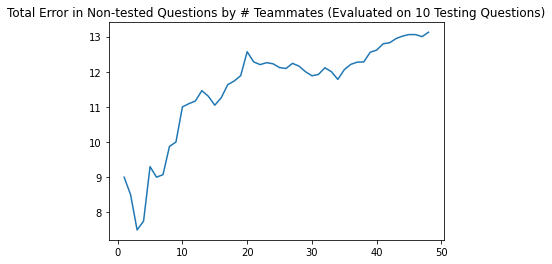

In [ ]:
num_teammates = np.subtract(list(49*np.ones(48)),list(dropped_dict.keys()))
plt.plot(num_teammates,dropped_dict.values())
plt.title("Total Error in Non-tested Questions by # Teammates (Evaluated on 10 Testing Questions)")